## Introduction

In this notebook we'll just try to model the lobbying data, ignoring the stock data.

In [217]:
from importlib import reload

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf

# Silencing a Pandas warning about date parsing
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")

pd.set_option('max_colwidth', 400)

In [218]:
from scripts.data_extraction import get_all_lobbying_data
lobbying_train = get_all_lobbying_data()

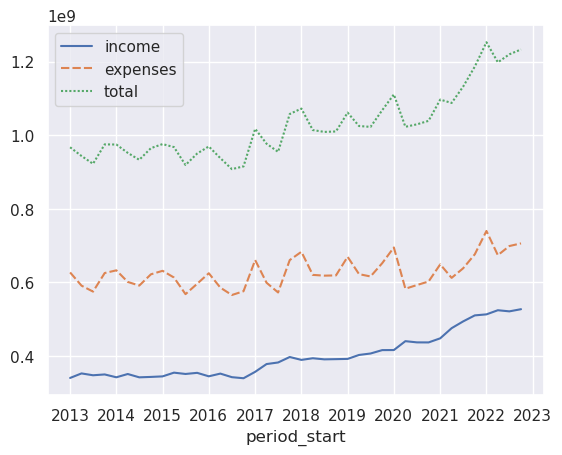

In [219]:
all_totals = lobbying_train.groupby("period_start")[["income", "expenses"]].sum()
all_totals["total"] = all_totals.sum(axis=1)
sns.lineplot(all_totals);

## An example: Apparel (APP)

In [169]:
filings = pd.read_csv("lobbying_data/by_issue_code/filings_APP.csv", parse_dates=["period_start", "period_end", "dt_posted"])
filings = filings[filings.period_start.dt.year < 2023]

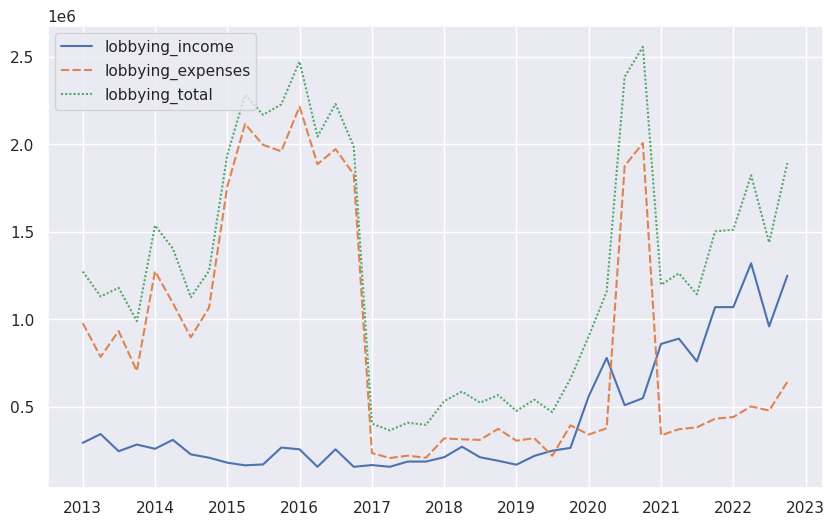

In [68]:
from scripts.data_extraction import lobbying_totals

plt.figure(figsize=(10,6))
sns.lineplot(lobbying_totals("APP"));

Each lobbying disclosure lists either "income" or "expenses", with "income" reported if a lobbying firm is hired, and "expenses" if an organization or individual is lobbying on their own behalf. The plot above has three interesting features: a sharp dip in expenses at the beginning of 2017, a gradual increase in income starting in 2020, and a large spike in expenses from Q3-Q4 2020. The total number of filings also jumps in 2020, as the chart below shows.

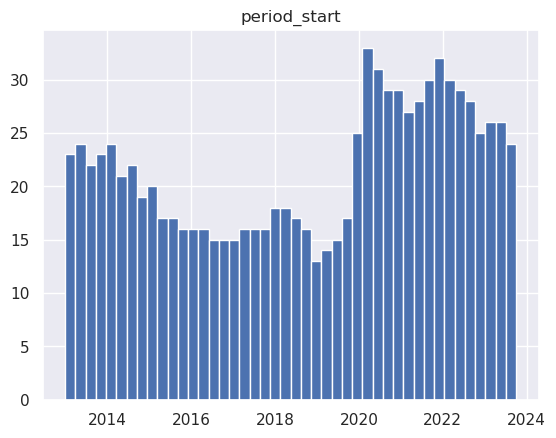

In [71]:
filings.hist("period_start", bins=filings.period_start.nunique());

From examining the filings, a clear concern before 2017 was the proposed Trans-Pacific Partnership (TPP), which would have increased competition for US textile exports [1]. Trump made withdrawal from TPP a major campaign proposal, and withdrew shortly after his inauguration in January 2017. As the plots below show, a large proportion of pre-2017 lobbying expenses was TPP related.

[1] Platzer, Michael D., [US Textile Manufacturing and the Proposed Trans-Pacific Partnership Agreement](https://sgp.fas.org/crs/misc/R44610.pdf), Congressional Research Service (2016).

array([[<Axes: title={'center': 'period_start'}>]], dtype=object)

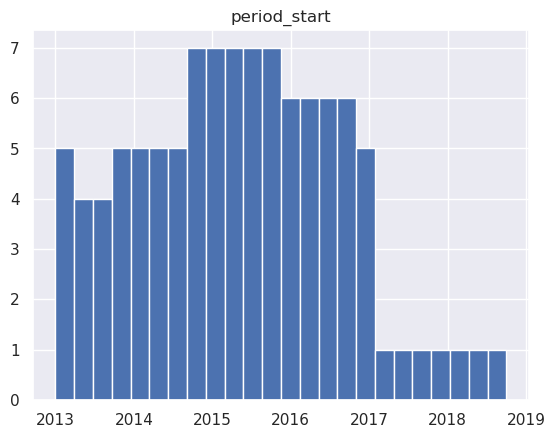

In [115]:
tpp = filings[
    filings.lobbying_description.str.contains("Trans-Pacific-Partnership", case=False)
    | filings.lobbying_description.str.contains("TPP")
]
tpp.hist("period_start", bins=tpp.period_start.nunique())


<Axes: >

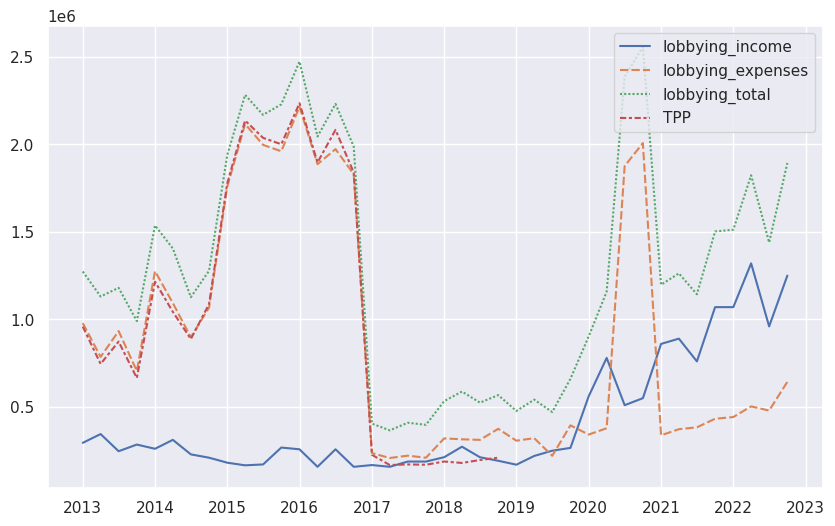

In [116]:
plt.figure(figsize=(10,6))
sns.lineplot(lobbying_totals("APP").merge(
    pd.DataFrame({"TPP": tpp.groupby("period_start")[["income", "expenses"]]
                  .sum().sum(axis=1)}),
    how="outer", left_index=True, right_index=True
))

All records after January 2017 mentioning TPP come from the American Apparel & Footwear Association, which was apparently reusing an out-of-date lobbying form.

In [120]:
from scripts.data_extraction import print_lobbying_summary
print_lobbying_summary(tpp.iloc[-7])

2017-04-01
Registrant:  AMERICAN APPAREL & FOOTWEAR ASSOCIATION
Client:  AMERICAN APPAREL & FOOTWEAR ASSOCIATION
Issue codes lobbied:  TRD, DEF, APP, TAR
Expenses:  168225.0
Discussions with Congress and Administration (including USTR, Commerce, ITC, Labor, State, Agriculture, the SEC, and Customs):
oon modernization of North American Free Trade Agreement (NAFTA).
oon implementation of free trade agreements (FTAs).
oon consideration of pending free trade agreements, including disposition of Trans-Pacific Partnership (TPP)
oon negotiation of new trade agreements, including Trans-Atlantic Trade and Investment Partnership (T-TIP), International Services Agreement (ISA), and Trade Facilitation agreement. Issues discussed include:
&#239;‚&#167;rules of origin
&#239;‚&#167;duties
&#239;‚&#167;customs provisions
&#239;‚&#167;IPR provisions
&#239;‚&#167;Regulatory harmonization
&#239;‚&#167;Transportation measures
&#239;‚&#167;Government procurement.
&#239;‚&#167;Port maintenance issues
oon th

The expenses spike in 2020 is due to two huge (~$1.5M) expenditures by Walmart. Walmart often has high lobbying expenditures, but rarely lobbies the APP issue code. One of the disclosures is below; the APP code is presumably related to "foreign assistance programs for global garment workers".

In [127]:
print_lobbying_summary(filings.iloc[611])

2020-10-01
Registrant:  WALMART INC.
Client:  WALMART INC
Issue codes lobbied:  TRD, DIS, HCR, ENV, IMM, TAX, VET, LAW, CSP, FOO, LBR, APP
Expenses:  1560000.0
Discussions regarding trade enforcement actions and tariff proposals by the Administration
Discussions regarding the U.S.-UK FTA
Discussions regarding Section 201 investigations into seasonal produce

Discussions related to the company's response to the Novel Corona Virus (Covid-19) pandemic.

Discussions include policy guidance related to transportation, supply chain, investments in associates and commitment to hiring, and trade in connection with COVID-19.

Discussions regarding employees benefits innovations
Discussions related to COVID-19 testing, vaccine administration and preparation including prioritization recommendations

Discussions regarding corporate sustainability initiatives

Discussions regarding support for legislative solution for Deferred Action for Childhood Arrivals (DACA)

Discussions related to H.R.4849, Up

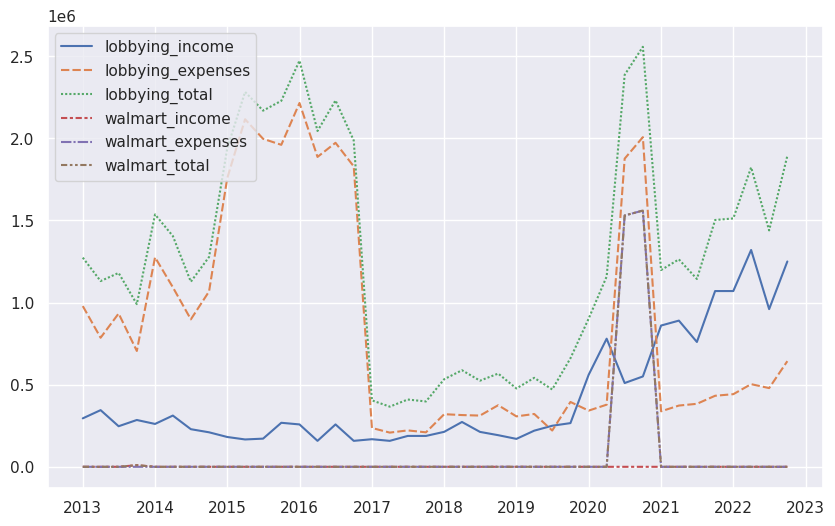

In [164]:
walmart_totals = filings[
    (filings.registrant.str.contains("Walmart", case=False))
    | (filings.client.str.contains("Walmart", case=False))
].groupby("period_start")[["income", "expenses"]].sum()
walmart_totals["total"] = walmart_totals.sum(axis=1)
walmart_totals.columns=["walmart_income", "walmart_expenses", "walmart_total"]

plt.figure(figsize=(10,6))
ax = sns.lineplot(lobbying_totals("APP").merge(
    walmart_totals, how="outer", left_index=True, right_index=True
).fillna(0))
sns.move_legend(ax, "upper left")

The increase in lobbying income 

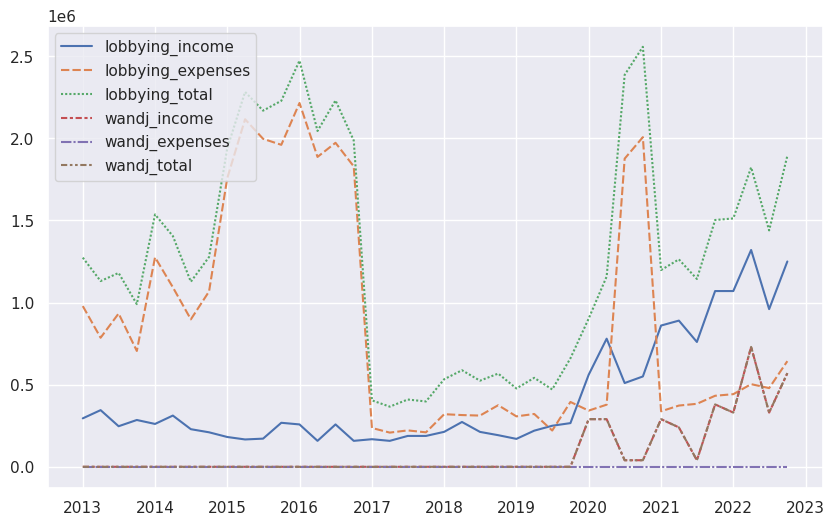

In [172]:
wandj_totals = filings[
    (filings.registrant.str.contains("williams and jensen", case=False))
    | (filings.client.str.contains("williams and jensen", case=False))
].groupby("period_start")[["income", "expenses"]].sum()
wandj_totals["total"] = wandj_totals.sum(axis=1)
wandj_totals.columns=["wandj_income", "wandj_expenses", "wandj_total"]

plt.figure(figsize=(10,6))
ax = sns.lineplot(lobbying_totals("APP").merge(
    wandj_totals, how="outer", left_index=True, right_index=True
).fillna(0))
sns.move_legend(ax, "upper left")

In [200]:
filings[
    # (filings.period_start >= pd.to_datetime("2020")) &
    (filings.income > 0)
].sort_values(by="income", ascending=False)[["registrant", "client", "income", "period_start"]].head(30)

,registrant,client,income,period_start
774,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,460000.0,2022-04-01
628,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,200000.0,2021-01-01
665,"WILLIAMS AND JENSEN, PLLC",TOM JAMES COMPANY,170000.0,2021-04-01
830,"WILLIAMS AND JENSEN, PLLC",W DIAMOND GROUP CORPORATION,140000.0,2022-10-01
291,MS. MISSY BRANSON,GLEN RAVEN INC 1831 NORTH PARK AVENUE GLEN RAVEN NC 27217,140000.0,2016-07-01
835,"VENTURE GOVERNMENT STRATEGIES, LLC (FKA HOBART HALLAWAY & QUAYLE VENTURES, LLC)",SHEIN TECHNOLOGY LLC,140000.0,2022-10-01
828,"WILLIAMS AND JENSEN, PLLC","HICKEY FREEMAN TAILORED CLOTHING, INC",130000.0,2022-10-01
829,"WILLIAMS AND JENSEN, PLLC",J.A. APPAREL CORP.,130000.0,2022-10-01
675,SQUIRE PATTON BOGGS,CINTAS CORPORATION,120000.0,2021-07-01
530,"WILLIAMS AND JENSEN, PLLC",GITMAN AND COMPANY,120000.0,2020-04-01


In [212]:
print_lobbying_summary(filings.iloc[717])

2021-10-01
Registrant:  WILLIAMS AND JENSEN, PLLC
Client:  TOM JAMES COMPANY
Issue codes lobbied:  APP, TRD, MAN
Income:  80000.0
Issues related to personal protective equipment; funding for PPE and buy American provisions (H.R. 3684; S. 1260; H.R. 1466; S. 869; American Recovery Act (H.R, 1319); Endless Frontier Act).

Duties on cotton and wool fabrics; 2018 Farm Bill implementation;  federal initiatives to support domestic manufacturing. Duties on Fabrics for PPEs.

Assistance for apparel and textile manufacturers.


<Axes: xlabel='period_start'>

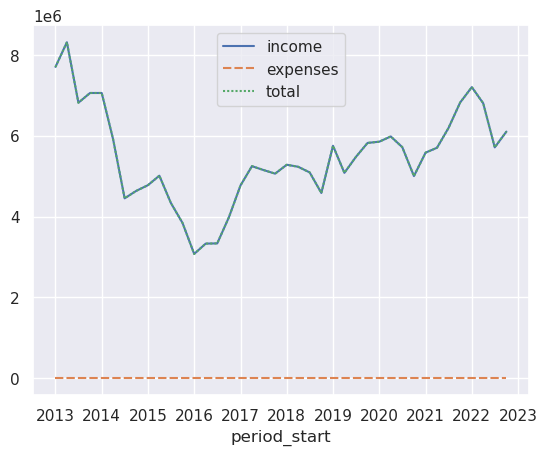

In [199]:
wandj = lobbying_train[lobbying_train.registrant.str.contains("squire patton boggs", case=False)]
wandj_totals = wandj.groupby("period_start")[["income", "expenses"]].sum()
wandj_totals["total"] = wandj_totals.sum(axis=1)
sns.lineplot(wandj_totals)
# wandj.period_start.hist(bins=wandj.period_start.nunique())

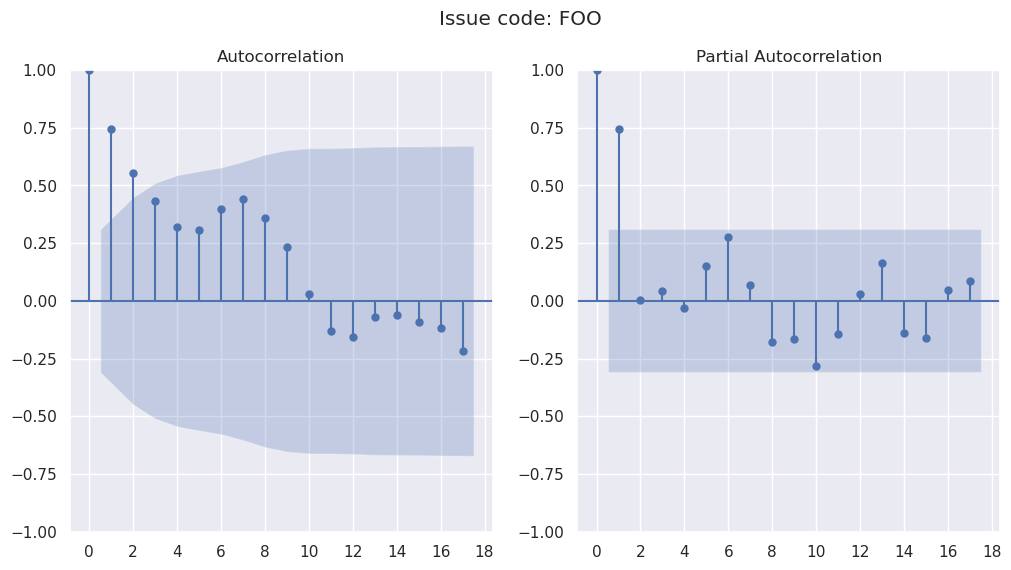

In [221]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MaxNLocator
def plot_acf_pacf(issue_codes):
    totals = lobbying_totals(issue_codes)["lobbying_total"]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    plot_acf(totals, ax=axs[0])
    plot_pacf(totals, ax=axs[1])
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.suptitle(f"Issue code: {issue_codes}")
    
plot_acf_pacf("FOO")

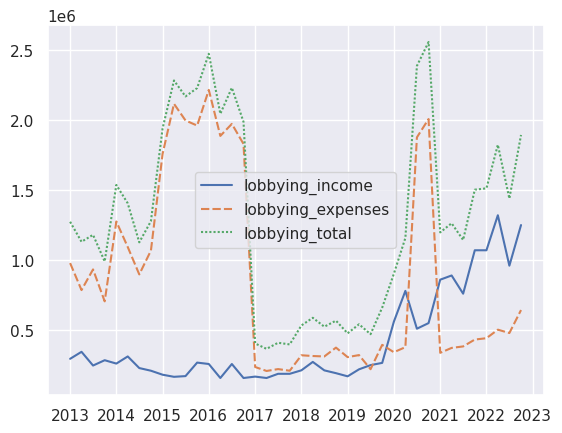

In [42]:
sns.lineplot(lobbying_totals("APP"));

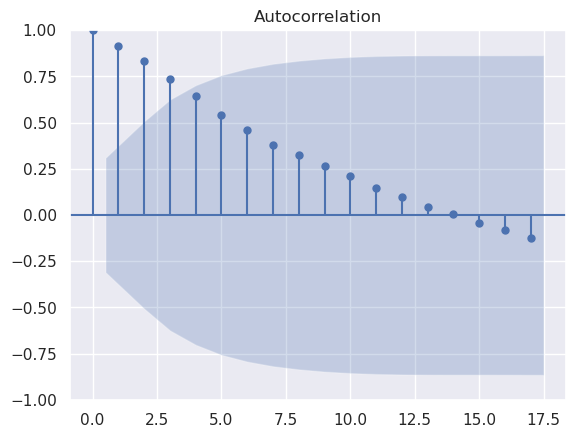

In [220]:
plot_acf(all_totals["income"]);